In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## Defining paths for the joints and time trajectories.

In [2]:
#Timing Law

def s(t): return -4*np.pi*(t/T)**3 + 6*np.pi*(t/T)**2
def s_dot(t): return (-12*np.pi*(t/T)**2 + 12*np.pi*t/T)/T

#Trajectory
r = np.pi;
def q_d(t): return np.array([r*np.cos(s(t)),r*np.sin(s(t)),r*np.sin(s(t))])
def q_d_dot(t): return np.array([-r*np.sin(s(t))*s_dot(t), r*np.cos(s(t))*s_dot(t),r*np.cos(s(t))*s_dot(t)])

In [3]:
def dir_kin(q):
    
    x=l1*np.cos(q[0])+l2*np.cos(q[0]+q[1])
    y=l1*np.sin(q[0])+l2*np.sin(q[0]+q[1])
    pos=[x,y]
    return pos

In [4]:
def dir_kin_elb(q):
    
    x=l1*np.cos(q[0])
    y=l1*np.sin(q[0])
    pos=[x,y]
    return pos

## Dynamical model of the 3R robot, along with the dynamical matrices.

In [20]:
# Robot Model
# Physicall parameters

T=2
A=1
C=3
D=2
E=1
F=2
Ixx=5
Iyy=2
Izz=3
L1=1
L2=1
L3=1
m1=5
m2=5
m3=5

a1=Iyy + m1*A**2+Iyy+m2*(L2-C)**2+Iyy+m3*(L3-D)**2+m3*(L2**2+E**2)
a2=Ixx-Iyy - m2*(L2-C)**2-m3*L2**2
a3=Ixx-Iyy-m3*(L3-D)**2
a4=2*m3*L2*(L3-D)
a7=m3*E*L2
a8=m3*E*(L3-D)
a5= Izz+m2*(L2-C)**2+Izz+m3*(L3-D)**2+m3*L2**2
a6= Izz+m3*(L3-D)**2

def C1(q):
    return 0.5*np.array([[0,2*a2*np.sin(q[1])*np.cos(q[1])+2*a3*np.sin(q[1]+q[2])*np.cos(q[1]+q[2]), 2*a3*np.sin(q[1]+q[2])*np.cos(q[1]+q[2])-2*a4*np.cos(q[1])*np.sin(q[1]+q[2])],[0, 2*a7-2*a8*np.cos(q[1]+q[2]), -2*a8*np.cos(q[1]+q[2])],[0,-2*a8*np.cos(q[1]+q[2]),-2*a8*np.cos(q[1]+q[2])]])
def c1(q,q_dot):
    return np.dot(q_dot,np.dot(C1(q),q_dot))

def C2(q):
    return 0.5*np.array([[-2*a2*np.sin(q[1])*np.cos(q[1])-2*a3*np.sin(q[1]+q[2])*np.cos(q[1]+q[2])-2*a4*np.sin(q[1])*np.sin(q[1]+q[2]),0,0],[a7*np.cos(q[1])+a3*np.cos(q[1]+q[2]),0,-2*a4*np.sin(q[2])],[a8*np.cos(q[1]+q[2]),0,-2*a4*np.sin(q[2])]])
def c2(q,q_dot):
    return np.dot(q_dot,np.dot(C2(q),q_dot))

def C3(q):
    return 0.5*np.array([[-2*a3*np.sin(q[1]+q[2])*np.cos(q[1]+q[2])+2*a4*np.cos(q[1])*np.sin(q[1]+q[2]),-a8*np.cos(q[1]+q[2]),-a8*np.cos(q[1]+q[2])],[a8*np.cos(q[1]+q[2]),2*a4*np.sin(q[2]),-a4*np.sin(q[2])],[a8*np.cos(q[1]+q[2]),a4*np.sin(q[2]),0]])
def c3(q,q_dot):
    return np.dot(q_dot,np.dot(C3(q),q_dot))

def c(q,q_dot):
    return np.array([c1(q,q_dot), c2(q,q_dot), c3(q,q_dot)])

def B(q):
    return np.array([[a1+a2*np.sin(q[1])**2+a3*np.sin(q[1]+q[2])**2+2*a4*np.cos(q[1])*np.cos(q[1]+q[2]),-a7*np.sin(q[1])-a8*np.sin(q[1]+q[2]), -a8*np.sin(q[1]+q[2])],[-a7*np.sin(q[1])-a8*np.sin(q[1]-q[2]), a5+2*a4*np.cos(q[2]), a6+ a4*np.cos(q[2])], [-a8*np.sin(q[1]+q[2]), a6+a4*np.cos(q[2]), a6]])

#def B(q): return np.array([[a1+2*a2*np.cos(q[1]),a2*np.cos(q[1])+a3],[a2*np.cos(q[1])+a3,a3]])
#def c(q,q_dot): return np.array([[-a2*np.sin(q[1])*(q_dot[1]**2 + 2*q_dot[0]*q_dot[1])],[ a2*np.sin(q[1])*q_dot[0]**2]])
#def g(q): return np.array([ [a4*np.cos(q[0])+a5*np.cos(q[0]+q[1])],[a5*np.cos(q[0]+q[1])]])

In [21]:
def dir_dyn(q,q_dot,q_ddot):
    q=np.asarray(q)
    q_dot=np.asarray(q_dot)
    q_ddot=np.asarray(q_ddot)
    u =np.dot(B(q),q_ddot) + c(q,q_dot) #+ g(q)
    return np.asarray(u)

In [22]:
def inv_dyn(q, q_dot, u):
    q=np.asarray(q)
    q_dot=np.asarray(q_dot)
    u=np.asarray(u)
  #  print(np.shape(c(q,q_dot)))
    u=u.reshape((3))
  #  print(np.shape(u))

    q=q.reshape(3)
    q_dot=q_dot.reshape(3)
 #   print(np.shape(u - c(q,q_dot) - g(q)))
#    print(q)
#    print(q_dot)


    q_ddot= np.dot(np.linalg.inv(B(q)), u - c(q,q_dot))# - g(q))
 #   print(u - c(q,q_dot))
 #   print(np.shape(q_ddot))
    return np.asarray(q_ddot)

## Neural network generation, evolution and feedforward.

In [23]:
def gen_rand_w():
    w_1= (np.random.randn(20,13))*0
    w_2 = (np.random.randn(20,21))*0
  #  w_3 = (np.random.randn(10,11))
  #  w_4 = (np.random.randn(15,16))
  #  w_5 = (np.random.randn(15,16))
  #  w_6 = (np.random.randn(15,16))
    w_3 = (np.random.randn(3,21))*0
    w=[]
    w.append(w_1)
    w.append(w_2)
    w.append(w_3)
 #   w.append(w_4)
#    w.append(w_5)
#    w.append(w_6)
#    w.append(w_7)
    return w

In [24]:
def evolve_w(w, alpha):
    
    dir=copy.deepcopy(w)
    dir[0]= (np.random.randn(20,13))*alpha
    dir[1] = (np.random.randn(20,21))*alpha
   # dir[2] += (np.random.randn(10,11))*alpha
  #  w[3] += (np.random.randn(15,16))*alpha
  #  w[4] += (np.random.randn(15,16))*alpha
  #  w[5] += (np.random.randn(15,16))*alpha
    dir[2] = (np.random.randn(3,21))*alpha
    
    w[0]+= dir[0]
    w[1] += dir[1]
  #  w[2] += (np.random.randn(10,11))*alpha
  #  w[3] += (np.random.randn(15,16))*alpha
  #  w[4] += (np.random.randn(15,16))*alpha
  #  w[5] += (np.random.randn(15,16))*alpha
    w[2] += dir[2]
  #  w[3] += dir[3]
    
    dir_flat=[]
    dir_flat=dir_flat+list(dir[0].flatten())
    dir_flat=dir_flat+list(dir[1].flatten())
    dir_flat=dir_flat+list(dir[2].flatten())
  #  print(dir_flat)
    return dir

In [25]:
def feedf(x, w):
    x=np.asarray(x)
    x=np.append(x,1)
    y=np.dot(w[0],x)
    y=np.tanh(y)
    y=np.append(y,1)
    y2=np.dot(w[1],y)
    y2=np.tanh(y2)
    y2=np.append(y2,1)
  
    y3=np.dot(w[2],y2)
    return y3

## Storing the steps of the time trajectory and velocity for each joint.

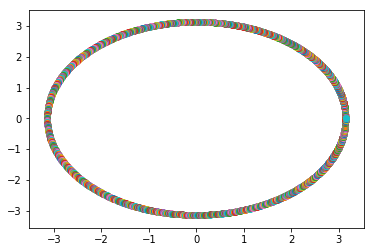

In [26]:
des_joints=[]
for i in range(0,2000):
    #100 steps che devono fare due circonferenze, dunque la freq è 2pi/50
    i*=0.001
    des_joints.append(q_d(i))
    plt.scatter(q_d(i)[0],q_d(i)[1])
plt.show()
#des_joints

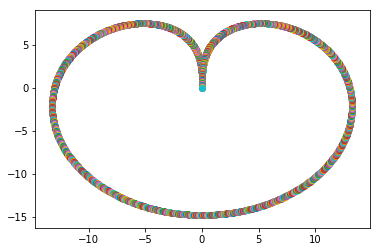

In [27]:
des_vel=[]
for i in range(0,2000):
    #100 steps che devono fare due circonferenze, dunque la freq è 2pi/50
    i*=0.001
    des_vel.append(q_d_dot(i))
    plt.scatter(q_d_dot(i)[0],q_d_dot(i)[1])
plt.show()
#des_joints

## Run function: it evaluates a complete run of the trajectory given a controller, computing the final loss (both position and velocity error) and plotting trajectories and torques.

In [28]:
#Prova a seguire la traiettoria
#manca la feedforward nominale della traiettoria

def run(w, plot=0, pid=0, clip=0):
    mov=[]
    mov_elb=[]
    joints=[]
    q=np.array([3.0,0.0, 0.0])
    q_dot=np.array([0.0,0.0, 0.0])
    u=np.array([0.01,0.01, 0.])

    kp=5000.0
    kd=1000.0
    
    u_clip=5000
    
    loss= 0
    u_pd1=[]
    u_nn1=[]
    u_pd2=[]
    u_nn2=[]
    u_pd3=[]
    u_nn3=[]
    u_tot1=[]
    u_tot2=[]
    u_tot3=[]
    q_1=[]
    q_2=[]
    q_3=[]
    
    ff_gain=70
    
    for t in range(0,2000):

        err=np.array([des_joints[t][0]-q[0],des_joints[t][1]-q[1],des_joints[t][2]-q[2]])
        err_vel=np.array([des_vel[t][0]-q_dot[0],des_vel[t][1]-q_dot[1],des_vel[t][2]-q_dot[2]])

        err=err.reshape((3,1))
        err_vel=err_vel.reshape((3,1))

 
        ff= feedf([q[0],q[1],q[2],q_dot[0],q_dot[1],q_dot[2],err[0],err[1],err[2],err_vel[0],err_vel[1],err_vel[2]],w)
        ff=ff.reshape((3,1))
        if (pid):
            u=kp*err + kd*err_vel + ff*0
        else:
            u=kp*err + kd*err_vel + ff*ff_gain
      #  u= 0.5*ff
   #     print((kp*err + kd*err_vel)[0])
   #     print((ff*20)[0][0])
        u_pd1.append((kp*err + kd*err_vel)[0][0])
        u_nn1.append((ff*ff_gain)[0][0])
        u_pd2.append((kp*err + kd*err_vel)[1][0])
        u_nn2.append((ff*ff_gain)[1][0])
        u_pd3.append((kp*err + kd*err_vel)[2][0])
        u_nn3.append((ff*ff_gain)[2][0])
      #  print(len(u))
       
        if clip:
            for i in range(len(u)):
                if u[i][0]>u_clip:
                    u[i][0]=u_clip
                if u[i][0]<-u_clip:
                    u[i][0]=-u_clip
        
        u_tot1.append(u[0][0])
        u_tot2.append(u[1][0])
        u_tot3.append(u[2][0])
        
        
        q_ddot=inv_dyn(q,q_dot,u)
        
   #     print(q_ddot)
        

        q_dot=q_dot.reshape((3))

    #    print(q_dot)
        q_dot+=q_ddot*0.001


     #   q=q.reshape((3))


        q+= q_dot*0.001

        q_1.append(q[0])
        q_2.append(q[1])
        q_3.append(q[2])
        
    #    if(plot):
          #  plt.scatter(q[0],q[1], color="red")
          #  plt.scatter(des_joints[t][0],des_joints[t][1], color="blue")
            
        
        loss+=np.linalg.norm(err)
        loss+=np.linalg.norm(err_vel)*0.2
      #  loss+=-np.exp(-np.linalg.norm(err)) 
      #  loss+=-np.exp(-np.linalg.norm(err_vel)) 
       # loss+=np.linalg.norm(u)*0.1
    if(plot):
        x_plot=np.linspace(0,2,2000)
        x_enum=np.linspace(0,1999,2000)
        print("Trajectories")
        print("Joint 1")
        plt.plot(np.linspace(0,1999,2000),q_1, color="blue")
        plt.plot(x_enum,q_d(x_plot)[0], color="red")
        plt.show()
        print("Joint 2")
        plt.plot(np.linspace(0,1999,2000),q_2, color="blue")
        plt.plot(x_enum,q_d(x_plot)[1], color="red")
        plt.show()
        print("Joint 3")
        plt.plot(np.linspace(0,1999,2000),q_3, color="blue")
        plt.plot(x_enum,q_d(x_plot)[2], color="red")
        plt.show()
     #   plt.plot(np.linspace(0,199,200),q_2, color="magenta")
     #   plt.plot(np.linspace(0,199,200),q_3, color="orange")
        
        
     #   print(u_pd)
     #   print(u_nn)
        print("TORQUES JOINT 1")
        plt.plot(np.linspace(0,1999,2000),u_pd1)
        plt.plot(np.linspace(0,1999,2000),u_nn1)
        plt.plot(np.linspace(0,1999,2000),u_tot1, color='red')
        plt.show()
        print("TORQUES JOINT 2")
        plt.plot(np.linspace(0,1999,2000),u_pd2)
        plt.plot(np.linspace(0,1999,2000),u_nn2)
        plt.plot(np.linspace(0,1999,2000),u_tot2, color='red')
        plt.show()
        print("TORQUES JOINT 3")
        plt.plot(np.linspace(0,1999,2000),u_pd3)
        plt.plot(np.linspace(0,1999,2000),u_nn3)
        plt.plot(np.linspace(0,1999,2000),u_tot3, color='red')
        plt.show()
    return loss

## Evolutionary algorithm. It evolves the network evaluating the new loss. If the new network has a better performance, it continues to evolve it in the chosen direction in parameters-space.

In [29]:
w=gen_rand_w()

w_try=gen_rand_w()
w_best=gen_rand_w()
count=0
loss_min=10000
#    alpha=0.2
for alpha in (0.7,0.2,0.05):
    for _ in range(0,20):
        count+=1
        print("new direction")
        w_try=copy.deepcopy(w_best)
        loss1=run(w_try, clip=1)
        print("loss 1: " + str(loss1))


        dir=evolve_w(w_try,alpha)
        loss2=run(w_try, clip=1)

        print("loss 2: " + str(loss2))

        diff=loss2-loss1
        while diff<-1:
            loss_min=loss2
            count+=1
            w_best=copy.deepcopy(w_try)
            print("improve")
            loss1=loss2
            
            w_try[0]+=dir[0]*0.33#*diff*0.05
            w_try[1]+=dir[1]*0.33#*diff*0.05
            w_try[2]+=dir[2]*0.33#*diff*0.05

            loss2=run(w_try, clip=1)
            diff=loss2-loss1

            print("loss new: " + str(loss2))
print("step totali: " + str(count))
print("best loss: " + str(loss_min) )

new direction
loss 1: 1985.4469949
loss 2: 2002.35122807
new direction
loss 1: 1985.4469949
loss 2: 1946.64045577
improve
loss new: 1935.1128823
improve
loss new: 1927.03022923
improve
loss new: 1926.51067902
new direction
loss 1: 1927.03022923
loss 2: 1868.83858977
improve
loss new: 1860.05588708
improve
loss new: 1857.70917292
improve
loss new: 1856.91122927
new direction
loss 1: 1857.70917292
loss 2: 1885.1373844
new direction
loss 1: 1857.70917292
loss 2: 1943.08436762
new direction
loss 1: 1857.70917292
loss 2: 1890.75177027
new direction
loss 1: 1857.70917292
loss 2: 1987.65766747
new direction
loss 1: 1857.70917292
loss 2: 2017.09183482
new direction
loss 1: 1857.70917292
loss 2: 1980.36129371
new direction
loss 1: 1857.70917292
loss 2: 1892.20370633
new direction
loss 1: 1857.70917292
loss 2: 1826.29754232
improve
loss new: 1846.54727408
new direction
loss 1: 1826.29754232
loss 2: 1804.88487727
improve
loss new: 1857.49849352
new direction
loss 1: 1804.88487727
loss 2: 1928.405

## TEST
## First the PD controller, our baseline, and then the evolutionary controller. The first 3 plots show the desired trajectory of each joint (red) and actual movement (blue).
## The last plots show the torques for each joint: PD (blue), EV controller (orange) and actual clipped torque given to the joints (red)

Trajectories
Joint 1


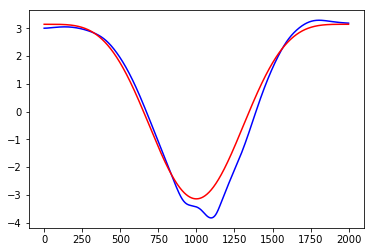

Joint 2


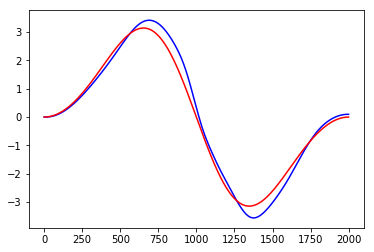

Joint 3


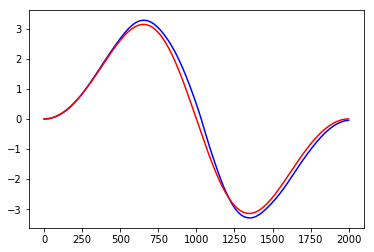

TORQUES JOINT 1


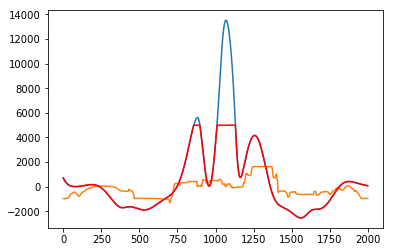

TORQUES JOINT 2


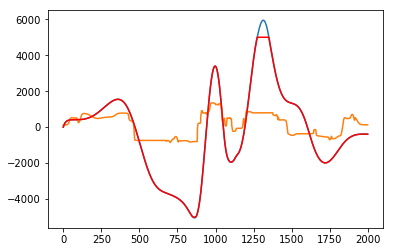

TORQUES JOINT 3


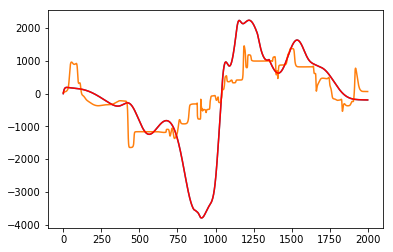

1985.4469948969574

In [30]:
run(w_best,plot=1,pid=1, clip=1)

Trajectories
Joint 1


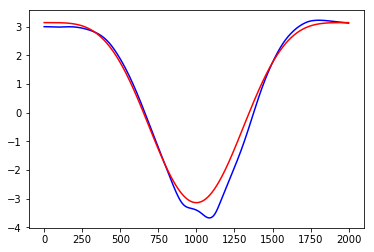

Joint 2


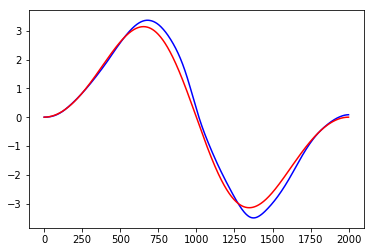

Joint 3


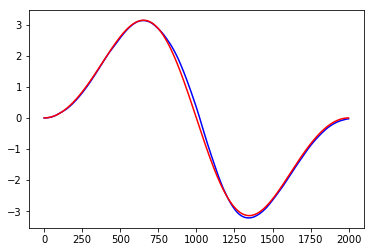

TORQUES JOINT 1


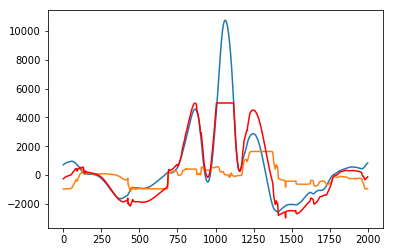

TORQUES JOINT 2


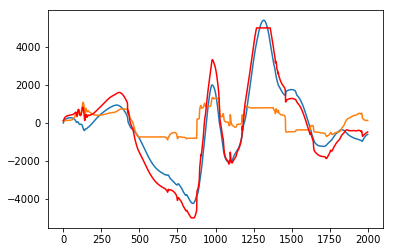

TORQUES JOINT 3


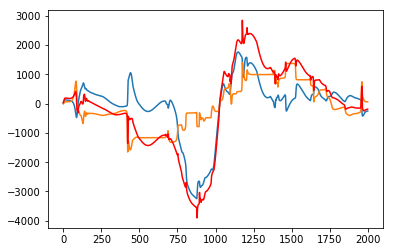

1562.5241524388346

In [31]:
run(w_best,plot=1,pid=0, clip=1)